# [ GLOW ] OOD Detection using FSS

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_GLOW
from core.data_loader import TRAIN_loader, TEST_loader
from core.fisher_utils_GLOW import Calculate_fisher_GLOW, Calculate_score_GLOW, AUTO_GLOW
from core.visualize import plot_hist, AUROC, plot_scores_all_layers

# fix a random seed
random.seed(2021)
np.random.seed(2021)
torch.manual_seed(2021)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Global Variables & Initialize

In [3]:
# FISHER_invs : Fisher inverse matrices from calculating Fisher score (w.r.t. train-dist)
FISHERs = {'cifar10': {}, 'fmnist': {}}
         
# NORMalize_FACtors : Normalizing Factor (w.r.t. train-dist)
NORM_FACs = {'cifar10': {}, 'fmnist': {}}
             
# SCOREs : (Scalars) Scores from calculating Fisher score (w.r.t. target-dist)
SCOREs = {'cifar10': {}, 'fmnist': {}}

# GLOW - CIFAR10

## 해체쇼 (Deprecated)

In [31]:
opt = config.GLOW_cifar10
model = load_pretrained_GLOW(option=opt.train_dist)
model.eval()

# Disassemble !!!
layers = {}
for i in range(29):
    if i in [0, 9, 19]:
    #if i in [0, 33, 67]:
        continue
    layers[f'flow{i}'] = model.flow.layers[i]

layers2 = {}
for lname, layer in layers.items():
    modules = dict(layer._modules)
    for key in modules.keys():
        layers2[f'{lname}_{key}'] = modules[key]

layers3 = {}
for lname, layer in layers2.items():
    if lname.split('_')[1] in ['actnorm', 'invconv']:
        continue
    modules = dict(layer._modules)
    conv_num = 0
    act_num = 0
    for key, value in modules.items():
        if isinstance(value, nn.ReLU):
            continue
        modules2 = dict(value._modules)
        for key2, value2 in modules2.items():
            if key2 == 'conv':
                conv_num += 1
                key3 = key2 + str(conv_num)
            elif key2 == 'actnorm':
                act_num += 1
                key3 = key2 + str(act_num)
            layers3[f'{lname}_{key3}'] = modules2[key2]
    
layers4 = {}
for key in layers2.keys():
    if key[-5:] != 'block':
        layers4[key] = layers2[key]
    else:
        for key2 in layers3.keys():
            if key2[:len(key)] == key:
                layers4[key2] = layers3[key2]
    

layers5 = {}
for lname, layer in layers4.items():
    attrs = layer._parameters.keys()
    for attr in attrs:
        x = getattr(layer, attr)
        if x == None: # ex: empty bias in conv
            continue
        else:
            layers5[f'{lname}_{attr}'] = x

params = layers5
    
        
        

## [1] Load the model & Parameter Selection

In [36]:
model

Glow(
  (flow): FlowNet(
    (layers): ModuleList(
      (0): SqueezeLayer()
      (1): FlowStep(
        (actnorm): ActNorm2d()
        (invconv): InvertibleConv1x1()
        (block): Sequential(
          (0): Conv2d(
            (conv): Conv2d(6, 400, kernel_size=(3, 3), stride=(1, 1), padding=[1, 1], bias=False)
            (actnorm): ActNorm2d()
          )
          (1): ReLU()
          (2): Conv2d(
            (conv): Conv2d(400, 400, kernel_size=(1, 1), stride=(1, 1), padding=[0, 0], bias=False)
            (actnorm): ActNorm2d()
          )
          (3): ReLU()
          (4): Conv2dZeros(
            (conv): Conv2d(400, 12, kernel_size=(3, 3), stride=(1, 1), padding=[1, 1])
          )
        )
      )
      (2): FlowStep(
        (actnorm): ActNorm2d()
        (invconv): InvertibleConv1x1()
        (block): Sequential(
          (0): Conv2d(
            (conv): Conv2d(6, 400, kernel_size=(3, 3), stride=(1, 1), padding=[1, 1], bias=False)
            (actnorm): ActNorm2d()


In [8]:
opt = config.GLOW_cifar10
model = load_pretrained_GLOW(option=opt.train_dist)
model.eval()

params = {
    'flow28': model.flow.layers[28]
}

In [11]:
for pname, param in params.items():
    for p in param.parameters():
        print(p.shape)

torch.Size([1, 48, 1, 1])
torch.Size([1, 48, 1, 1])
torch.Size([48, 48])
torch.Size([48])
torch.Size([48, 48])
torch.Size([400, 24, 3, 3])
torch.Size([1, 400, 1, 1])
torch.Size([1, 400, 1, 1])
torch.Size([400, 400, 1, 1])
torch.Size([1, 400, 1, 1])
torch.Size([1, 400, 1, 1])
torch.Size([48, 1, 1])
torch.Size([48, 400, 3, 3])
torch.Size([48])


## Additional Training (Deprecated)

In [92]:
for param in model.parameters():
    param.requires_grad_(False)
for param in model.flow.layers[28].invconv.parameters():
    param.requires_grad_(True)

import torch.optim as optim
from torch.autograd import Variable
from datetime import datetime

device = 'cuda:0'
optimizer = optim.Adamax(model.flow.layers[28].invconv.parameters(), lr=1e-4, weight_decay=0)
loader = TRAIN_loader('cifar10')
start = datetime.now()

for epoch in range(10):
    mean_loss = 0.
    for i, (x, _) in enumerate(loader):
        x = x.to(device)
        z, nll, y_logits = model(x, None)
        loss = torch.mean(nll)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mean_loss = (mean_loss * i + loss.detach().item()) / (i + 1)
        
    now = datetime.now()
    print(f'Epoch {epoch+1:02d} mean_loss {mean_loss:.2f} Elapsed time {now - start}')
    
    

Files already downloaded and verified
Epoch 01 mean_loss 21373.91 Elapsed time 0:04:00.977587


KeyboardInterrupt: 

## [2] Compute Fisher inverse & Fisher score

Files already downloaded and verified


Calculate Fisher GLOW:   0%|                                                                                                                                                                                                                      | 0/50000 [00:00<?, ?step/s]

328420


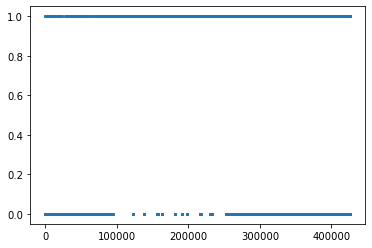

Calculate Fisher GLOW:   0%|                                                                                                                                                                                                           | 1/50000 [00:02<41:19:07,  2.98s/step]

330434


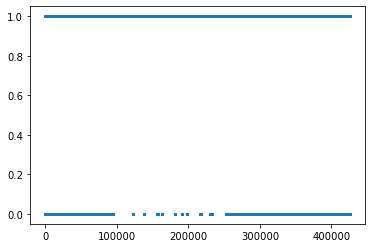

Calculate Fisher GLOW:   0%|                                                                                                                                                                                                           | 2/50000 [00:03<19:09:22,  1.38s/step]

329931


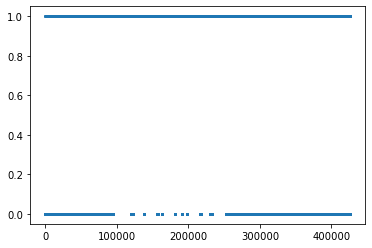

Calculate Fisher GLOW:   0%|                                                                                                                                                                                                           | 3/50000 [00:03<12:04:20,  1.15step/s]

328348


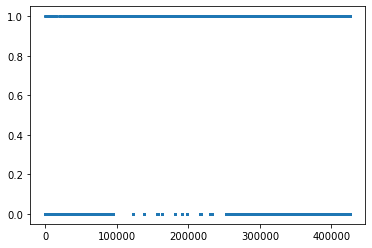

Calculate Fisher GLOW:   0%|                                                                                                                                                                                                            | 4/50000 [00:03<8:44:39,  1.59step/s]

329797


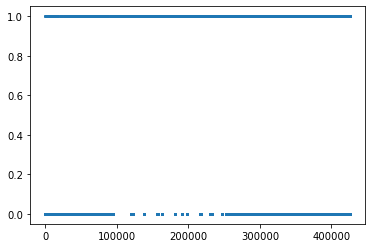

Calculate Fisher GLOW:   0%|                                                                                                                                                                                                            | 5/50000 [00:04<6:54:16,  2.01step/s]

328515


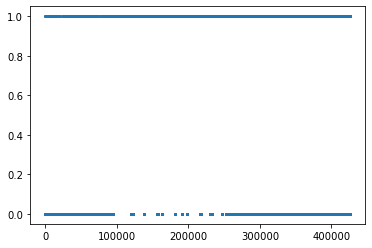

Calculate Fisher GLOW:   0%|                                                                                                                                                                                                            | 6/50000 [00:04<5:48:00,  2.39step/s]

329461


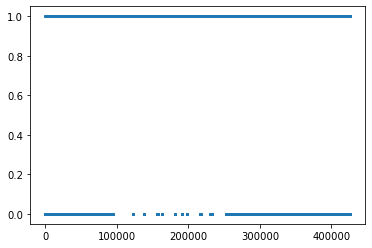

Calculate Fisher GLOW:   0%|                                                                                                                                                                                                            | 7/50000 [00:04<5:06:45,  2.72step/s]

328429


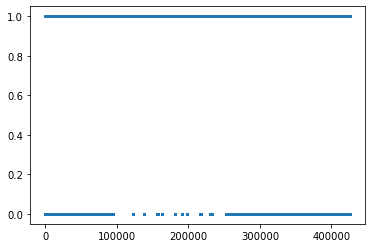

Calculate Fisher GLOW:   0%|                                                                                                                                                                                                            | 8/50000 [00:04<4:38:56,  2.99step/s]

329559


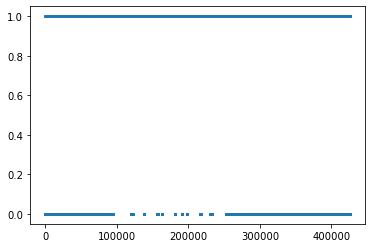

Calculate Fisher GLOW:   0%|                                                                                                                                                                                                            | 9/50000 [00:05<4:19:47,  3.21step/s]

331100


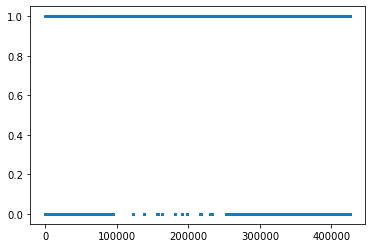

Calculate Fisher GLOW:   0%|                                                                                                                                                                                                           | 10/50000 [00:05<4:07:18,  3.37step/s]

327491


Calculate Fisher GLOW:   0%|                                                                                                                                                                                                           | 10/50000 [00:05<7:59:12,  1.74step/s]


KeyboardInterrupt: 

In [35]:
method = 'Vanilla'
a, b, _scores = AUTO_GLOW(opt, model, params, max_iter=[10000, 5000], method=method)

## [3] Get AUROC

In [5]:
for pname in params.keys():
    FISHERs[opt.train_dist][pname] = a[pname] 
    NORM_FACs[opt.train_dist][pname] = b[pname]
for ood in opt.ood_list:
    SCOREs[opt.train_dist][ood] = _scores[ood]

# AUROC curve
auroc = {}
for pname in params.keys():
    _auroc = {}
    for ood in opt.ood_list:
        args = [
            SCOREs[opt.train_dist][opt.train_dist][pname],
            SCOREs[opt.train_dist][ood][pname],
        ]
        labels = [opt.train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[pname] = _auroc
    
df = pd.DataFrame(auroc).T
df = df.iloc[:, 1:]
df

,svhn,celeba,lsun,cifar100,mnist,fmnist,kmnist,omniglot,notmnist,trafficsign,noise,constant
flow28_invconv_lower,0.870467,0.706320,0.719399,0.577263,0.712286,0.700900,0.815581,0.732952,0.930154,0.656894,1.0,0.760544
flow28_invconv_log_s,0.842957,0.661977,0.689770,0.568523,0.589838,0.578485,0.687715,0.548026,0.905761,0.657011,1.0,0.965018
flow28_invconv_upper,0.881398,0.707697,0.732504,0.571615,0.588868,0.578050,0.731311,0.609711,0.919938,0.664255,1.0,0.679152


In [6]:
temp = {}
for ood in opt.ood_list:
    temp[ood] = SCOREs[opt.train_dist][ood].copy()

In [7]:
s = {}
for ood in opt.ood_list:
    try:
        s[ood] += temp[ood][pname]
    except:
        s[ood] = temp[ood][pname]
        
auroc = {}
for ood in opt.ood_list:
    args = [s[opt.train_dist], s[ood]]
    labels = [opt.train_dist, ood]
    auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    
auroc

{'cifar10': 0.5,
 'svhn': 0.8813980999999999,
 'celeba': 0.70769654,
 'lsun': 0.7325042000000002,
 'cifar100': 0.5716147,
 'mnist': 0.5888682599999999,
 'fmnist': 0.5780502000000001,
 'kmnist': 0.7313113200000001,
 'omniglot': 0.60971098,
 'notmnist': 0.919938,
 'trafficsign': 0.66425508,
 'noise': 1.0,
 'constant': 0.67915236}

In [28]:
auroc = {}
for ood in opt.ood_list:
    in_sum = 0
    out_sum = 0
    for pname in params.keys():
        try:
            in_sum += np.array(SCOREs[opt.train_dist][opt.train_dist][pname])
            out_sum += np.array(SCOREs[opt.train_dist][ood][pname])
        except:
            in_sum = np.array(SCOREs[opt.train_dist][opt.train_dist][pname])
            out_sum = np.array(SCOREs[opt.train_dist][ood][pname])
    args = [
        in_sum,
        out_sum,
    ]

    labels = [opt.train_dist, ood]
    
    auroc[ood] = AUROC(*args, labels=labels, verbose=False)

auroc

{'cifar10': 0.5, 'svhn': 0.0, 'celeba': 0.0, 'lsun': 0.0}

In [30]:
print(SCOREs[opt.train_dist]['cifar10'])
print(SCOREs[opt.train_dist]['svhn'])

{'flow28_invconv_lower': array([0.01826269, 0.01861855, 0.01927181, ..., 0.01627278, 0.01769829,
       0.0144948 ], dtype=float32), 'flow28_invconv_log_s': array([0.0017084 , 0.00178753, 0.00177009, ..., 0.00139408, 0.00165807,
       0.00120105], dtype=float32), 'flow28_invconv_upper': array([0.0007756 , 0.00074737, 0.00085358, ..., 0.00080441, 0.00074704,
       0.00074754], dtype=float32)}
{'flow28_invconv_lower': array([0.00099169, 0.00085825, 0.00099795, ..., 0.00092485, 0.00108708,
       0.00095772], dtype=float32), 'flow28_invconv_log_s': array([0.00248206, 0.00220631, 0.00212421, ..., 0.00149722, 0.00191713,
       0.00188069], dtype=float32), 'flow28_invconv_upper': array([0.0008896 , 0.00078601, 0.00087852, ..., 0.00079614, 0.00095663,
       0.00088242], dtype=float32)}


In [53]:
x = list(df.index)
xx = []
for elt in x:
    if elt.split('_')[1] == 'invconv':
        if elt.split('_')[2] == 'lower':
                xx.append(elt)

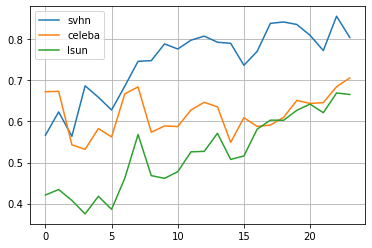

In [54]:
x = range(len(xx))
plt.plot(x, df.loc[xx, 'svhn'], label='svhn')
plt.plot(x, df.loc[xx, 'celeba'], label='celeba')
plt.plot(x, df.loc[xx, 'lsun'], label='lsun')
plt.grid()
plt.legend()


# GLOW - FMNIST

## Load the model & Parameter Selection

In [166]:
opt = config.GLOW_fmnist
model = load_pretrained_GLOW(option=opt.train_dist)
model.eval()

layers = {}
for i in range(29):
    if i in [0, 9, 19]:
    #if i in [0, 33, 67]:
        continue
    layers[f'flow{i}'] = model.flow.layers[i]

layers2 = {}
for lname, layer in layers.items():
    modules = dict(layer._modules)
    for key in modules.keys():
        layers2[f'{lname}_{key}'] = modules[key]

## Compute Fisher inverse & Fisher score

In [73]:
method = 'Vanilla'
a, b, _scores = AUTO_GLOW(opt, model, layers2, max_iter=[1, 500], method=method)

Calculate Score GLOW:   5%|██▋                                                   | 499/10000 [00:38<12:15, 12.91step/s]


## Get AUROC

In [83]:
layers = layers2

for lname in layers.keys():
    FISHERs[train_dist][lname] = a[lname] 
    NORM_FACs[train_dist][lname] = b[lname]
for ood in opt.ood_list:
    SCOREs[train_dist][ood] = _scores[ood]

# AUROC curve
auroc = {}
for lname in layers.keys():
    _auroc = {}
    for ood in opt.ood_list:
        if ood == 'noise':
            continue
        args = [
            SCOREs[train_dist][train_dist][lname],
            SCOREs[train_dist][ood][lname],
        ]
        labels = [train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[lname] = _auroc
    
df = pd.DataFrame(auroc).T
df = df.iloc[:, 1:]
df

,mnist,kmnist,notmnist,constant
flow1_actnorm,0.999956,0.999972,0.995712,0.999944
flow1_invconv,0.992520,0.982936,0.962584,0.968748
flow1_block,1.000000,1.000000,1.000000,1.000000
flow2_actnorm,0.999996,0.999996,0.998196,1.000000
flow2_invconv,0.999112,0.998556,0.975644,0.992816
...,...,...,...,...
flow27_invconv,0.061844,0.071596,0.370832,0.276684
flow27_block,0.972340,0.950224,0.983928,0.998192
flow28_actnorm,0.311968,0.437160,0.561520,0.597460
flow28_invconv,0.005700,0.031140,0.157432,0.068472


In [87]:
x = list(df.index)
xx = []
for elt in x:
    if elt.split('_')[1] == 'block':
        xx.append(elt)

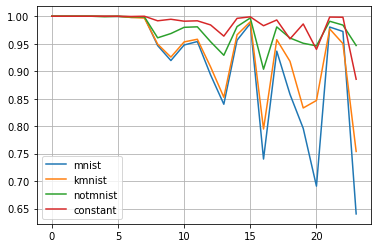

In [88]:
x = range(len(xx))
plt.plot(x, df.loc[xx, 'mnist'], label='mnist')
plt.plot(x, df.loc[xx, 'kmnist'], label='kmnist')
plt.plot(x, df.loc[xx, 'notmnist'], label='notmnist')
plt.plot(x, df.loc[xx, 'constant'], label='constant')
plt.grid()
plt.legend()

## Check the reconstruction ability of GLOW

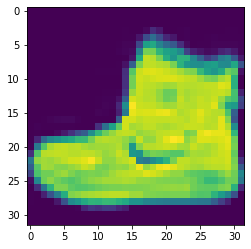

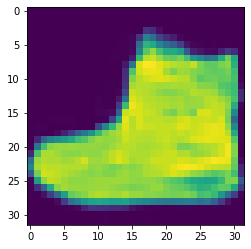

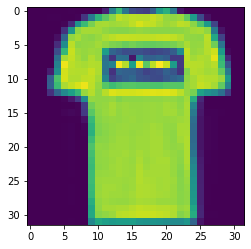

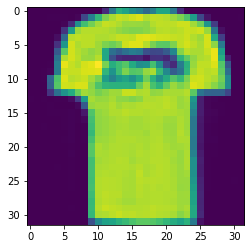

In [171]:
def postprocess(x):
    x = torch.clamp(x, -0.5, 0.5)
    x += 0.5
    x = x * 256
    return torch.clamp(x, 0, 255).byte()

loader = TEST_loader('fmnist', 'fmnist', shuffle=False, is_glow=True)
for i, x in enumerate(loader):
    try:
        x, _ = x
    except:
        pass
    y = postprocess(x)
    plt.figure()
    plt.imshow(y[0].permute(1, 2, 0).cpu())
    x = x.to('cuda')
    z, _, _ = model(x = x)
    x = model(z=z, temperature=0.75, reverse=True)
    y = postprocess(x)
    plt.figure()
    plt.imshow(y[0].permute(1, 2, 0).cpu())
    if i == 1:
        break
plt.show()

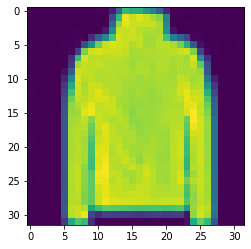

In [104]:
plt.imshow(x[0].permute(1,2,0).cpu())